## Imports + Setup

In [1]:
from scripts.solver import Solver
from scripts.dataset import custom_collate, SpriteDataset
from scripts.evaluate_disentanglement import main as eval_dis
from torch.utils.data import DataLoader
import copy
import os
from itertools import chain

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

#"""
## dSprites used for demo, see dataset.py for other datasets.
data_loader = DataLoader(SpriteDataset(prior='laplace', #(LAP); 'uniform' for (LOC)
                                       rate=-1, #random rate (for LAP)
                                       k=-1), #random k (for LOC), see https://arxiv.org/abs/2002.02886
                         batch_size=32,
                         shuffle=True,
                         num_workers=2,
                         pin_memory=True,
                         drop_last=True,
                         collate_fn=custom_collate)
#"""
if not os.path.exists('outputs'):
    os.makedirs('outputs')
exp_params = {'cuda': False,
              'ckpt_dir': 'checkpoints',
              'output_dir': 'outputs',
              'dataset': 'dsprites',
              'max_iter': 1, #300000 used for experiments
              'z_dim': 10,
              'num_channel': 1,
              'lr': 1e-4,
              'beta1': 0.9,
              'beta2': 0.999,
              'ckpt_name': 'last',
              'log_step': 1000,
              'save_step': 10000,
              'batch_size': 64
             }
slowvae = {'gamma': 10, 'rate_prior': 6, 'beta': 1}
betavae = {'gamma': 0, 'rate_prior': 0, 'beta': 8}
beta_params = dict(chain.from_iterable(d.items() for d in (exp_params, betavae)))
beta_params['betavae'] = True
slow_params = dict(chain.from_iterable(d.items() for d in (exp_params, slowvae)))
slow_params['betavae'] = False
net_beta = Solver(AttrDict(beta_params), data_loader=data_loader)
net_slow = Solver(AttrDict(slow_params), data_loader=data_loader)

## Training

In [2]:
_ = net_slow.train(None)
#_ = net_beta.train(None)

<Figure size 1440x1152 with 0 Axes>

## Quantitative Evaluation

In [3]:
## MIG for evaluation, see evaluate_disentanglement.py for other metrics
from disentanglement_lib.evaluation.metrics import mig
import numpy as np
import torch
import gin.tf
gin.enter_interactive_mode()

net = net_slow.net
#net = net_beta.net
def mean_rep(x):
    distributions = net._encode(torch.from_numpy(x).float())
    mu = distributions[:, :net.z_dim]
    logvar = distributions[:, net.z_dim:]
    return np.array(mu.detach().cpu())

gin_bindings = [
    "evaluation.evaluation_fn = @mig",
    "evaluation.random_seed = 0",
    "mig.num_train=1000", #100000 used in paper
    "discretizer.discretizer_fn = @histogram_discretizer",
    "discretizer.num_bins = 20"
]
@gin.configurable("evaluation")
def evaluate(evaluation_fn=gin.REQUIRED,
             random_seed=gin.REQUIRED):
        results_dict = evaluation_fn(ground_truth_data=data_loader.dataset, 
                               representation_function=mean_rep,
                               random_state=np.random.RandomState(random_seed))
        return results_dict
gin.parse_config_files_and_bindings([], gin_bindings)
results_dict = evaluate()
gin.clear_config()
gin.config._REGISTRY.clear()

In [4]:
import pprint
pprint.pprint(results_dict)

{'discrete_mig': 0.007249349725032328}


## Qualitative Evaluation

In [5]:
from matplotlib import pyplot as plt

In [7]:
# get some latent embeddings
bs, ls = [], []
n_total = 0
for b, l in data_loader:
    bs.append(b[::2])
    ls.append(l[::2])
    n_total += b[::2].shape[0]
    if n_total >= 1000:
        break
bs = torch.cat(bs)
ls = torch.cat(ls)
zs = net_slow.net._encode(bs)

In [8]:
def plot_latents(zs, labels, factor_names, show=False):
    mus = zs.detach().cpu().numpy()[:, :10]
    logvars = zs.detach().cpu().numpy()[:, 10:]
    labels = labels.detach().cpu().numpy()
    num_factors = labels.shape[1]

    fig, ax = plt.subplots(5, num_factors, figsize=(26, 20))


    sorting = np.argsort(np.var(mus, 0))[::-1]
    for i in range(5):
        ind_x = sorting[0+i*2]
        ind_y = sorting[1+i*2]
        for j in range(num_factors):
            ax_i = ax[i, j]
            ax_i.set_title(f'color coded by: {factor_names[j]}, states {np.max(labels, axis=0)[j]}')
            scat = ax_i.scatter( mus[:, ind_x], mus[:, ind_y],  s=.1, c=labels[:, j])
            ax_i.set_xlabel('Latent %s, mean_var=%.4f' % (ind_x, np.mean(np.exp(logvars[:, ind_x]))))
            ax_i.set_ylabel('Latent %s, mean_var=%.4f' % (ind_y, np.mean(np.exp(logvars[:, ind_y]))))

    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.3, wspace = 0.3)

    return fig

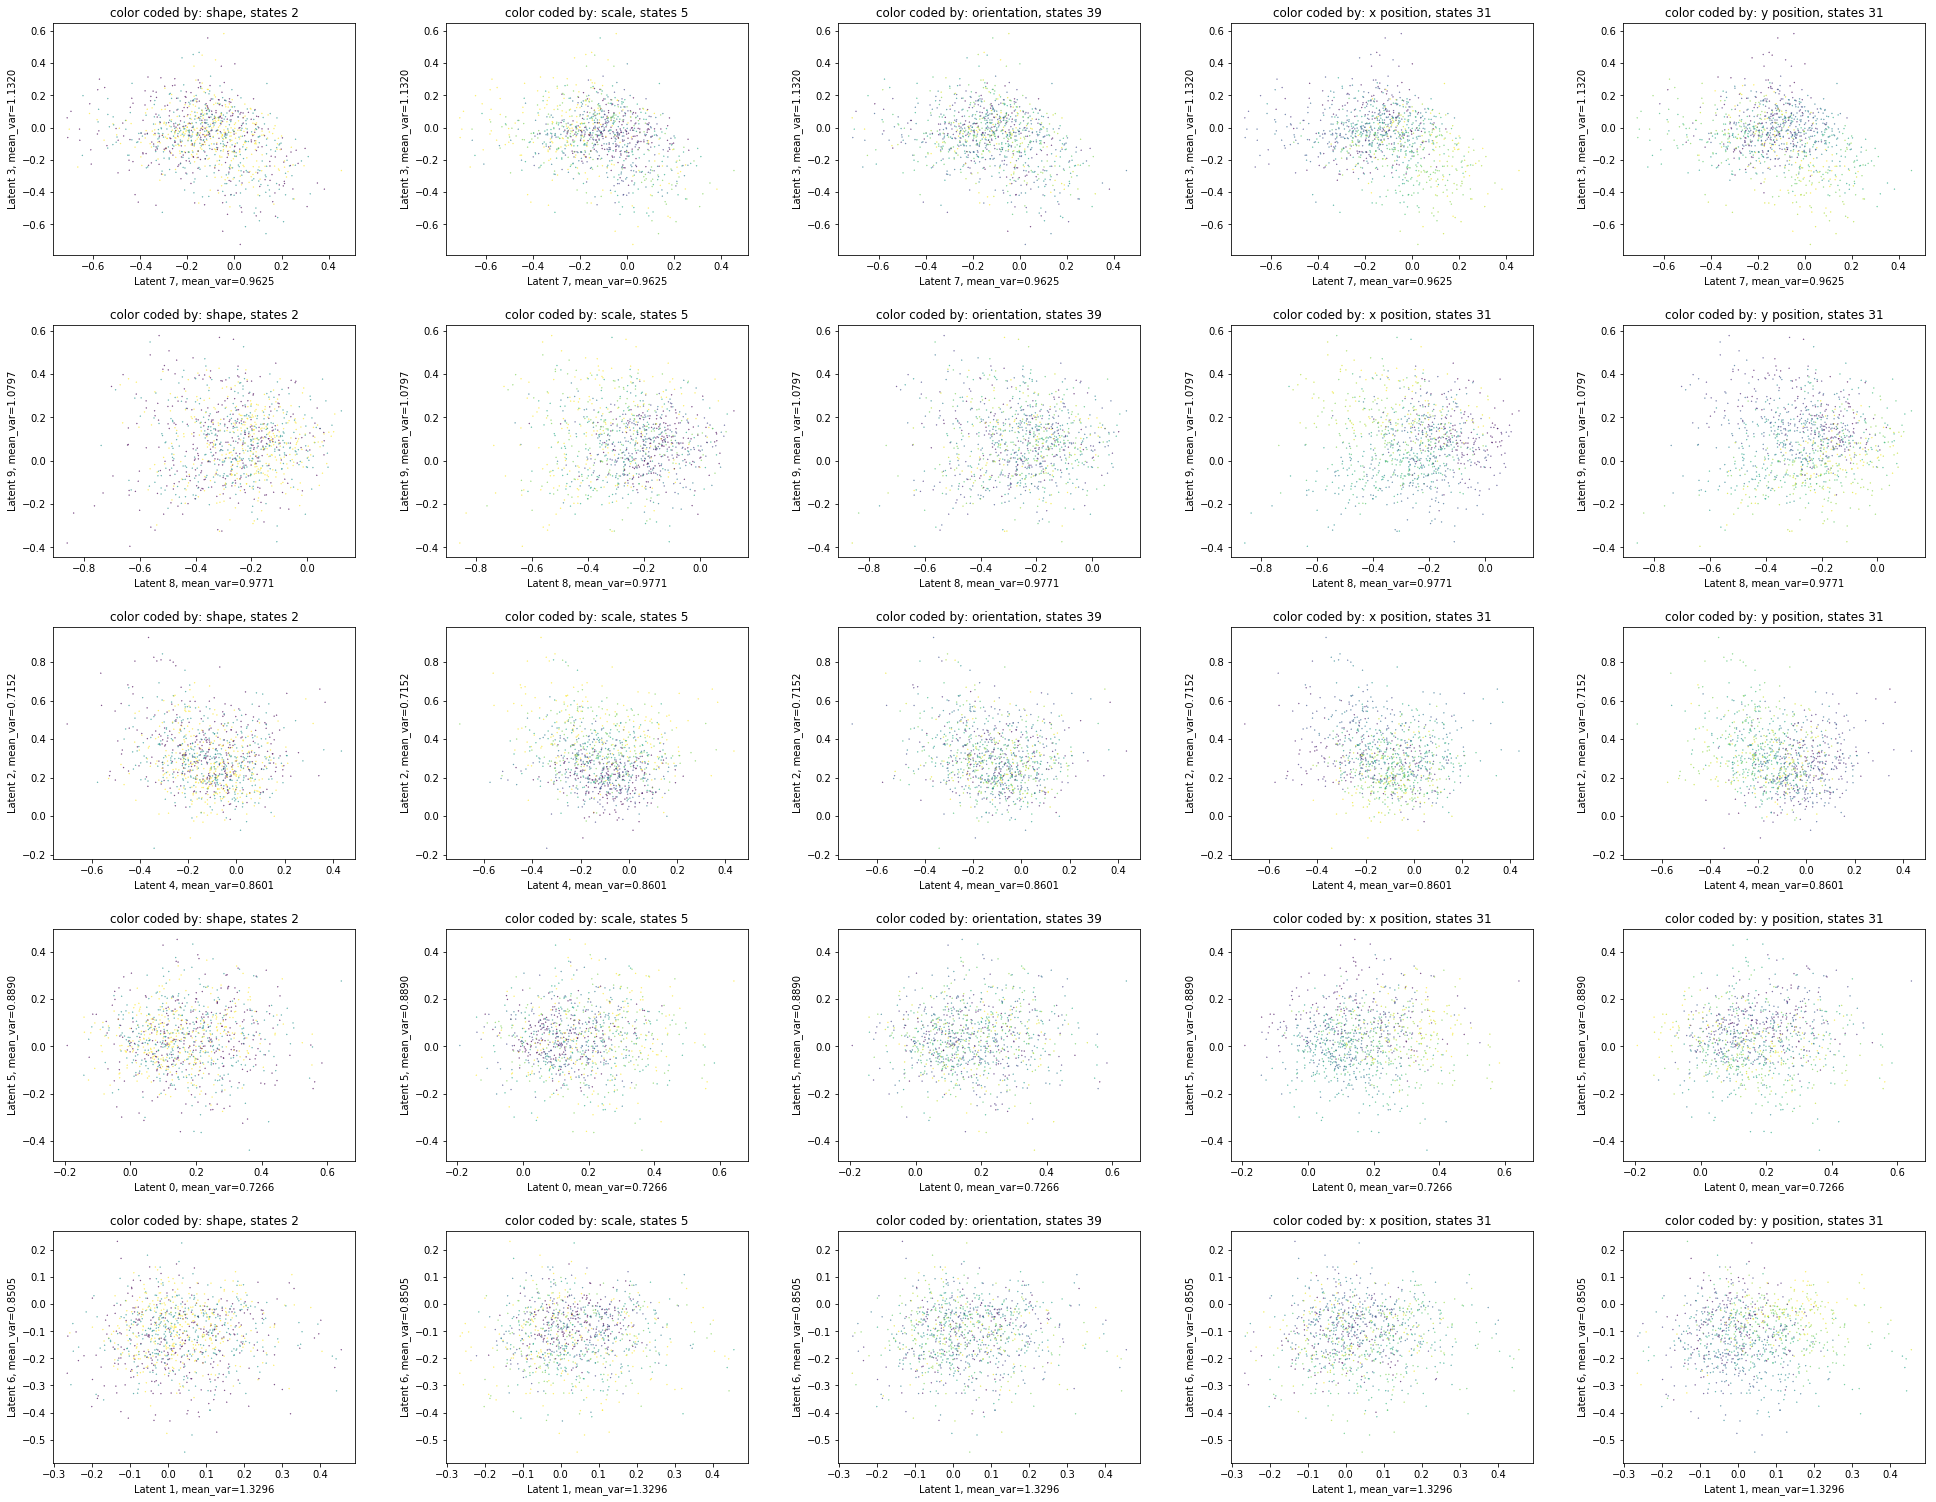

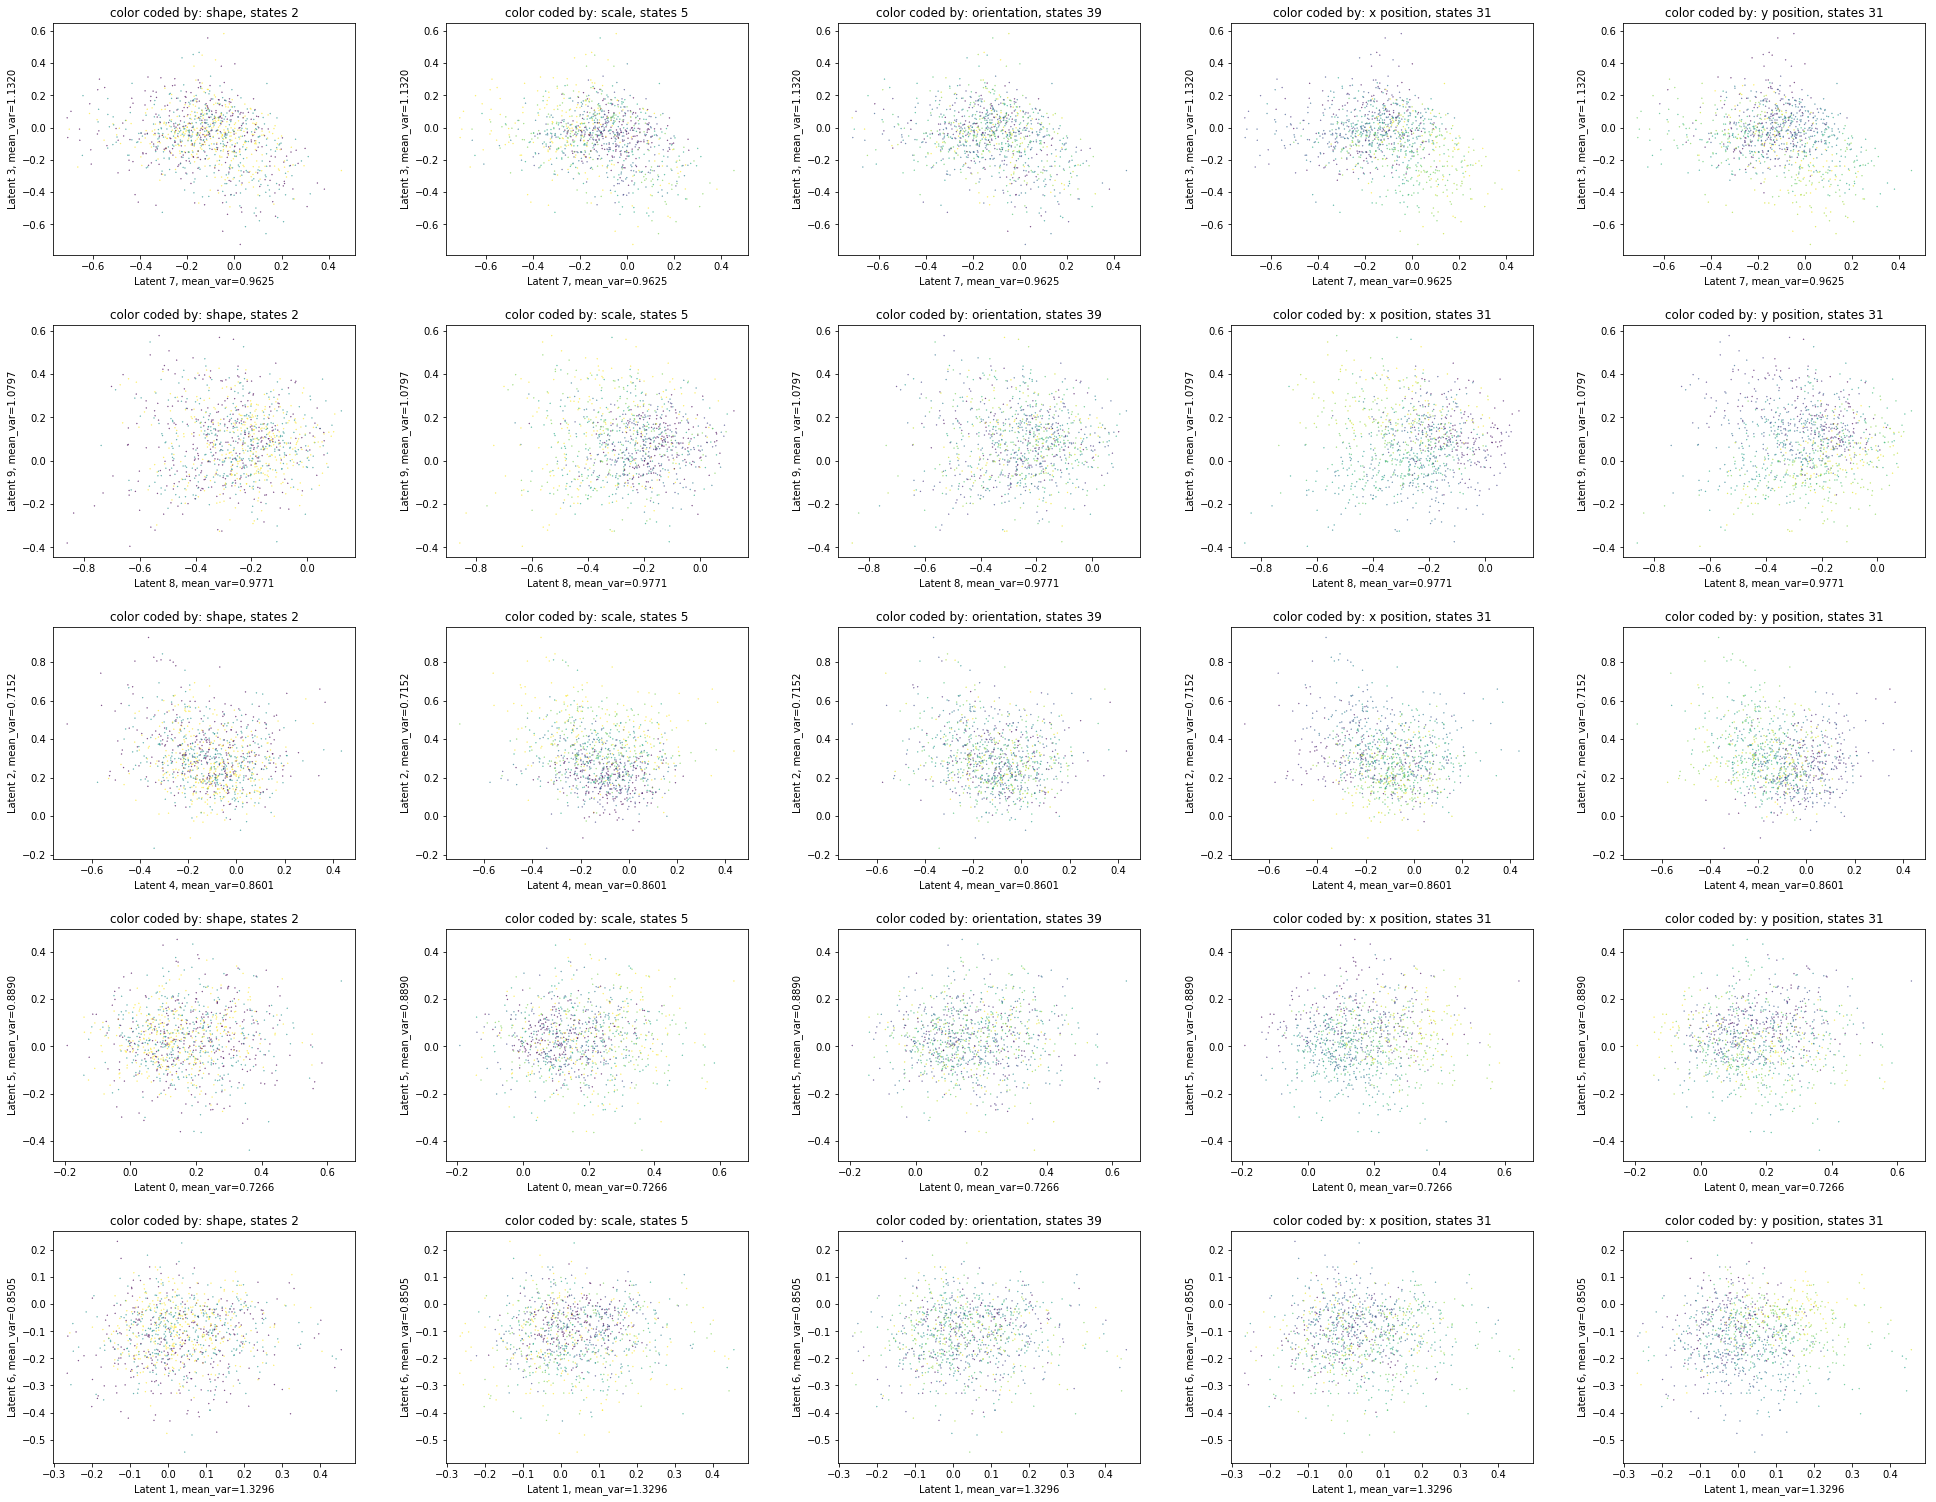

In [9]:
plot_latents(zs, ls, ['shape', 'scale', 'orientation', 'x position', 'y position'])